# Executive Summary

# Introduction

# Data Discussion

#  Methodology

In the completion of this project, the methodology below were used in developing a Diabetes Retinopathy classifier model.

    1. Data Extraction
    2. Data Preprocessing
    3. Model Selection
    4. Fine Tuning
    5. Analysis of Results

<center><img src="picture\methodology.png" alt="methodology" width="900" height="700"></center>

<center><strong>Methodology</strong></center>

# Data Extraction

This section extracts all the images in the dataset using different convulotional base, Xception, InceptionResNet-V2 and VGG16. Before the feeding the images to the convolutional base, each image is resized to 1024x1024. The model will extract the relevant features of the images and transform it into a vector based on the convolutional base used.

## Import Libraries

In [19]:
import os
import warnings
import json
import boto3
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.bag as db
import dask.dataframe as dd
import tensorflow as tf
import keras.applications.inception_resnet_v2 as inception_resnet
import keras.applications.xception as xception
import keras.applications.vgg16 as vgg16
from keras import backend
from keras.models import Model, Input, Sequential, load_model
from keras.preprocessing.image import load_img, img_to_array
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Dropout, Input, Conv2D
from keras.callbacks import (ModelCheckpoint, LearningRateScheduler,
                             EarlyStopping, ReduceLROnPlateau)
from PIL import Image
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import metrics
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from collections import Counter
from imblearn.over_sampling import SMOTE 
from tqdm.notebook import tqdm

In [11]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


Tensor Flow Version: 2.4.0
Keras Version: 2.4.0
GPU is available


In [12]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [13]:
from IPython.display import display, clear_output
from IPython.display import Audio
from IPython.core.display import HTML
import numpy as np

def alert(duration=2):
    """ makes sound on client using javascript (works with remote server) """      
    framerate = 44100
    freq=300
    t = np.linspace(0,duration,framerate*duration)
    data = np.sin(2*np.pi*freq*t)
    display(Audio(data,rate=framerate, autoplay=True))

## Assign Constant Variables

In [110]:
BUCKET = 'kapeles'
DATA_PATH ='BDCC_Dataset/downloads/manual'
TRAIN_PATH =  os.path.join(DATA_PATH, 'train')
TEST_PATH = os.path.join(DATA_PATH, 'test')
SAMPLE_PATH = os.path.join(DATA_PATH, 'sample')

XCEPTION_VECTOR_PATH = 'BDCC_Dataset/xception_vectors'
INCEPTION_VECTOR_PATH = 'BDCC_Dataset/inception_resnet_vectors'
VGG_VECTOR_PATH = 'BDCC_Dataset/vgg16_vectors_2'
TARGET_SIZE = (1024, 1024)

## Extract Image Vectors
***Warning:*** Extracting image vectors using the convolutional base would take approximately 1 day with GPU hardware.

This section extracts the image vectors based on different convolutional base for all the images in the dataset.

In [7]:
s3 = boto3.resource('s3', region_name='us-east-2')
bucket = s3.Bucket(BUCKET)

### Extract image vectors based on Xception

#### Create Xception base

In [85]:
# Xception base without top layer and specified input shape
def create_xception_base():
    """Create untrainable xception model"""
    base = xception.Xception(weights='imagenet',
                                              include_top=False,
                                              input_shape=(TARGET_SIZE +
                                                           tuple([3])),
                                              pooling='avg')
    # Freeze layers
    for layer in base.layers:
        layer.trainable=False
        
    return base

base = create_xception_base()
base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 511, 511, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 511, 511, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 511, 511, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

#### Predict each images using Xception base

In [7]:
def get_image(key, bucket):
    """Return numpy array of image from the s3 bucket"""
    obj = bucket.Object(key)
    response = obj.get()
    file_stream = response['Body']
    im = Image.open(file_stream).resize(TARGET_SIZE)
    return np.array(im)
    

def write_json_file(data, filename):
    """Write json file in the XCEPTION_VECTOR_PATH"""
    key = os.path.join(XCEPTION_VECTOR_PATH, filename)
    (s3.Object(BUCKET, key)
     .put(Body=bytes(json.dumps(data).encode('UTF-8'))))
    

def read_json_file(filename):
    """Reads json file in the XCEPTION_VECTOR_PATH"""
    obj = bucket.Object(os.path.join(XCEPTION_VECTOR_PATH, filename))
    response = obj.get()
    file_content = response['Body'].read()
    return json.loads(file_content)

In [14]:
# Extract images from train path
file_no = 100
train_images = list(bucket.objects.filter(Prefix=TRAIN_PATH))
count = len(train_images)
print('Extracting image vectors for {} images'.format(count))
images = []
for idx in range(count):
    obj = train_images[idx]
    try:
        # Get the numpy matrix of the image
        dct = dict()
        img = get_image(obj.key, bucket)
        
        # Preprocess input based on the training of convolutional base
        nimage = xception.preprocess_input(img)
        nimage = np.expand_dims(nimage, axis=0)
        
        # Extracted image vectors
        image_vector = base.predict(nimage)
        image_vector = np.reshape(image_vector, image_vector.shape[1:])
        
        dct["name"] = os.path.basename(obj.key)
        dct["value"] = image_vector.tolist()
        images.append(dct)
        
        # Check the image is in the hundredth or the last image
        if (not file_no // (idx + 1)) or count == (idx + 1):
            file_name = f'train_{file_no//100}.json'
            write_json_file(images, file_name)
            file_no += 100
            images = []
    except Exception as e:
        alert(5)
        print('Unable to read {}:{}'.format(idx, obj.key)) 

In [15]:
# Extract images from test path
file_no = 100
test_images = list(bucket.objects.filter(Prefix=TEST_PATH))
count = len(test_images)
print('Extracting image vectors for {} images'.format(count))
images = []
for idx in range(count):
    obj = test_images[idx]
    try:
        # Get the numpy matrix of the image
        dct = dict()
        img = get_image(obj.key, bucket)
        
        # Preprocess input based on the training of convolutional base
        nimage = xception.preprocess_input(img)
        nimage = np.expand_dims(nimage, axis=0)
        
        # Extracted image vectors
        image_vector = base.predict(nimage)
        image_vector = np.reshape(image_vector, image_vector.shape[1:])
        
        dct["name"] = os.path.basename(obj.key)
        dct["value"] = image_vector.tolist()
        images.append(dct)
        
        # Check the image is in the hundredth or the last image
        if (not file_no // (idx + 1)) or count == (idx + 1):
            file_name = f'test_{file_no//100}.json'
            write_json_file(images, file_name)
            file_no += 100
            images = []
    except Exception as e:
        print('Unable to read {}:{}'.format(idx, obj.key)) 

In [9]:
# Extract images from sample path
file_no = 100
sample_images = list(bucket.objects.filter(Prefix=SAMPLE_PATH))
count = len(sample_images)
print('Extracting image vectors for {} images'.format(count))
images = []
for idx in range(count):
    obj = sample_images[idx]
    try:
        # Get the numpy matrix of the image
        dct = dict()
        img = get_image(obj.key, bucket)
        
        # Preprocess input based on the training of convolutional base
        nimage = xception.preprocess_input(img)
        nimage = np.expand_dims(nimage, axis=0)
        
        # Extracted image vectors
        image_vector = base.predict(nimage)
        image_vector = np.reshape(image_vector, image_vector.shape[1:])
        
        dct["name"] = os.path.basename(obj.key)
        dct["value"] = image_vector.tolist()
        images.append(dct)
        
        # Check the image is in the hundredth or the last image
        if (not file_no // (idx + 1)) or count == (idx + 1):
            file_name = f'sample_{file_no//100}.json'
            write_json_file(images, file_name)
            file_no += 100
            images = []
    except Exception as e:
        print('Unable to read {}:{}'.format(idx, obj.key)) 

### Extract image vectors based on InceptionResNetV2

#### Create Inception Resnset V2 base

In [88]:
# Inception Resnet V2 base without top layer and specified input shape
def create_inceptionresnet_base():
    """Create untrainable inception resnet v2 model"""
    base = inception_resnet.InceptionResNetV2(weights='imagenet',
                                              include_top=False,
                                              input_shape=(TARGET_SIZE +
                                                           tuple([3])),
                                              pooling='avg')
    # Freeze layers
    for layer in base.layers:
        layer.trainable=False
    return base


base = create_inceptionresnet_base()
base.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 511, 511, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 511, 511, 32) 96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 511, 511, 32) 0           batch_normalization_4[0][0]      
________________________________________________________________________________

#### Predict each images using Inception Resnet V2 base

In [7]:
def get_image(key, bucket):
    """Return numpy array of image from the s3 bucket"""
    obj = bucket.Object(key)
    response = obj.get()
    file_stream = response['Body']
    im = Image.open(file_stream).resize(TARGET_SIZE)
    return np.array(im)
    

def write_json_file(data, filename):
    """Write json file in the INCEPTION_VECTOR_PATH"""
    key = os.path.join(INCEPTION_VECTOR_PATH, filename)
    (s3.Object(BUCKET, key)
     .put(Body=bytes(json.dumps(data).encode('UTF-8'))))
    

def read_json_file(filename):
    """Reads json file in the INCEPTION_VECTOR_PATH"""
    obj = bucket.Object(os.path.join(INCEPTION_VECTOR_PATH, filename))
    response = obj.get()
    file_content = response['Body'].read()
    return json.loads(file_content)

In [14]:
# Extract images from train path
file_no = 100
train_images = list(bucket.objects.filter(Prefix=TRAIN_PATH))
count = len(train_images)
print('Extracting image vectors for {} images'.format(count))
images = []
for idx in range(count):
    obj = train_images[idx]
    try:
        # Get the numpy matrix of the image
        dct = dict()
        img = get_image(obj.key, bucket)
        
        # Preprocess input based on the training of convolutional base
        nimage = inception_resnet.preprocess_input(img)
        nimage = np.expand_dims(nimage, axis=0)
        
        # Extracted image vectors
        image_vector = base.predict(nimage)
        image_vector = np.reshape(image_vector, image_vector.shape[1:])
        
        dct["name"] = os.path.basename(obj.key)
        dct["value"] = image_vector.tolist()
        images.append(dct)
        
        # Check the image is in the hundredth or the last image
        if (not file_no // (idx + 1)) or count == (idx + 1):
            file_name = f'train_{file_no//100}.json'
            write_json_file(images, file_name)
            file_no += 100
            images = []
    except Exception as e:
        alert(5)
        print('Unable to read {}:{}'.format(idx, obj.key)) 

In [15]:
# Extract images from test path
file_no = 100
test_images = list(bucket.objects.filter(Prefix=TEST_PATH))
count = len(test_images)
print('Extracting image vectors for {} images'.format(count))
images = []
for idx in range(count):
    obj = test_images[idx]
    try:
        # Get the numpy matrix of the image
        dct = dict()
        img = get_image(obj.key, bucket)
        
        # Preprocess input based on the training of convolutional base
        nimage = inception_resnet.preprocess_input(img)
        nimage = np.expand_dims(nimage, axis=0)
        
        # Extracted image vectors
        image_vector = base.predict(nimage)
        image_vector = np.reshape(image_vector, image_vector.shape[1:])
        
        dct["name"] = os.path.basename(obj.key)
        dct["value"] = image_vector.tolist()
        images.append(dct)
        
        # Check the image is in the hundredth or the last image
        if (not file_no // (idx + 1)) or count == (idx + 1):
            file_name = f'test_{file_no//100}.json'
            write_json_file(images, file_name)
            file_no += 100
            images = []
    except Exception as e:
        print('Unable to read {}:{}'.format(idx, obj.key)) 

In [9]:
# Extract images from sample path
file_no = 100
sample_images = list(bucket.objects.filter(Prefix=SAMPLE_PATH))
count = len(sample_images)
print('Extracting image vectors for {} images'.format(count))
images = []
for idx in range(count):
    obj = sample_images[idx]
    try:
        # Get the numpy matrix of the image
        dct = dict()
        img = get_image(obj.key, bucket)
        
        # Preprocess input based on the training of convolutional base
        nimage = inception_resnet.preprocess_input(img)
        nimage = np.expand_dims(nimage, axis=0)
        
        # Extracted image vectors
        image_vector = base.predict(nimage)
        image_vector = np.reshape(image_vector, image_vector.shape[1:])
        
        dct["name"] = os.path.basename(obj.key)
        dct["value"] = image_vector.tolist()
        images.append(dct)
        
        # Check the image is in the hundredth or the last image
        if (not file_no // (idx + 1)) or count == (idx + 1):
            file_name = f'sample_{file_no//100}.json'
            write_json_file(images, file_name)
            file_no += 100
            images = []
    except Exception as e:
        print('Unable to read {}:{}'.format(idx, obj.key)) 

### Extract image vectors based on VGG16 base

#### Create VGG16 base

In [89]:
# VGG16 base without top layer and specified input shape
def create_vgg_base():
    """Create untrainable vgg16 model"""
    base = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(TARGET_SIZE +
                                    tuple([3])),
                       pooling='avg')
    # Freeze layers
    for layer in base.layers:
        layer.trainable = False
    return base


base = create_vgg_base()
base.summary()

58892288/58889256 [==============================] - 19s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1024, 1024, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 1024, 1024, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 1024, 1024, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 512, 512, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 512, 512, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 512, 512, 128)     147584    
_____________________________________________________________

#### Predict each images using Inception Resnet V2 base

In [7]:
def get_image(key, bucket):
    """Return numpy array of image from the s3 bucket"""
    obj = bucket.Object(key)
    response = obj.get()
    file_stream = response['Body']
    im = Image.open(file_stream).resize(TARGET_SIZE)
    return np.array(im)
    

def write_json_file(data, filename):
    """Write json file in the VGG_VECTOR_PATH"""
    key = os.path.join(VGG_VECTOR_PATH, filename)
    (s3.Object(BUCKET, key)
     .put(Body=bytes(json.dumps(data).encode('UTF-8'))))
    

def read_json_file(filename):
    """Reads json file in the VGG_VECTOR_PATH"""
    obj = bucket.Object(os.path.join(VGG_VECTOR_PATH, filename))
    response = obj.get()
    file_content = response['Body'].read()
    return json.loads(file_content)

In [14]:
# Extract images from train path
file_no = 100
train_images = list(bucket.objects.filter(Prefix=TRAIN_PATH))
count = len(train_images)
print('Extracting image vectors for {} images'.format(count))
images = []
for idx in range(count):
    obj = train_images[idx]
    try:
        # Get the numpy matrix of the image
        dct = dict()
        img = get_image(obj.key, bucket)
        
        # Preprocess input based on the training of convolutional base
        nimage = inception_resnet.preprocess_input(img)
        nimage = np.expand_dims(nimage, axis=0)
        
        # Extracted image vectors
        image_vector = base.predict(nimage)
        image_vector = np.reshape(image_vector, image_vector.shape[1:])
        
        dct["name"] = os.path.basename(obj.key)
        dct["value"] = image_vector.tolist()
        images.append(dct)
        
        # Check the image is in the hundredth or the last image
        if (not file_no // (idx + 1)) or count == (idx + 1):
            file_name = f'train_{file_no//100}.json'
            write_json_file(images, file_name)
            file_no += 100
            images = []
    except Exception as e:
        alert(5)
        print('Unable to read {}:{}'.format(idx, obj.key)) 

In [15]:
# Extract images from test path
file_no = 100
test_images = list(bucket.objects.filter(Prefix=TEST_PATH))
count = len(test_images)
print('Extracting image vectors for {} images'.format(count))
images = []
for idx in range(count):
    obj = test_images[idx]
    try:
        # Get the numpy matrix of the image
        dct = dict()
        img = get_image(obj.key, bucket)
        
        # Preprocess input based on the training of convolutional base
        nimage = inception_resnet.preprocess_input(img)
        nimage = np.expand_dims(nimage, axis=0)
        
        # Extracted image vectors
        image_vector = base.predict(nimage)
        image_vector = np.reshape(image_vector, image_vector.shape[1:])
        
        dct["name"] = os.path.basename(obj.key)
        dct["value"] = image_vector.tolist()
        images.append(dct)
        
        # Check the image is in the hundredth or the last image
        if (not file_no // (idx + 1)) or count == (idx + 1):
            file_name = f'test_{file_no//100}.json'
            write_json_file(images, file_name)
            file_no += 100
            images = []
    except Exception as e:
        print('Unable to read {}:{}'.format(idx, obj.key)) 

In [9]:
# Extract images from sample path
file_no = 100
sample_images = list(bucket.objects.filter(Prefix=SAMPLE_PATH))
count = len(sample_images)
print('Extracting image vectors for {} images'.format(count))
images = []
for idx in range(count):
    obj = sample_images[idx]
    try:
        # Get the numpy matrix of the image
        dct = dict()
        img = get_image(obj.key, bucket)
        
        # Preprocess input based on the training of convolutional base
        nimage = inception_resnet.preprocess_input(img)
        nimage = np.expand_dims(nimage, axis=0)
        
        # Extracted image vectors
        image_vector = base.predict(nimage)
        image_vector = np.reshape(image_vector, image_vector.shape[1:])
        
        dct["name"] = os.path.basename(obj.key)
        dct["value"] = image_vector.tolist()
        images.append(dct)
        
        # Check the image is in the hundredth or the last image
        if (not file_no // (idx + 1)) or count == (idx + 1):
            file_name = f'sample_{file_no//100}.json'
            write_json_file(images, file_name)
            file_no += 100
            images = []
    except Exception as e:
        print('Unable to read {}:{}'.format(idx, obj.key)) 

## Setup Dask Cluster

In [20]:
# Create dask cluster
client = Client('172.31.31.30:8786')

# Register progress bar
pbar = ProgressBar()
pbar.register()

# Get AWS Config
# Note: use own AWS config
# with open('setting_aws.pkl', 'rb') as f:
#     settings_aws = pickle.load(f)

# Show cluster
client

Client Scheduler: tcp://172.31.31.30:8786 Dashboard: http://172.31.31.30:8787/status,Cluster Workers: 4 Cores: 24 Memory: 100.93 GB


## Read Image Vector Dataset

In [61]:
def calculate_pcc(y):
    """Calculate and print out PCC to beat"""
    values = np.bincount(y)
    pcc = ((values/values.sum())**2).sum()
    print('Pcc : %.2f'%(pcc*100) +'%')
    print('Accuracy (1.25Pcc) required : %.2f'%(pcc*100*1.25) +'%' )

In [174]:
test_label_path = ('s3://kapeles/BDCC_Dataset/downloads/'
                   'kagg-foru-mess-atta_9052_2877_reti_solupq'
                   '89ZoBOgYh9qJuSYbz7faT1us7bBw8bXbg_qHmrYMk.csv')
train_label_path = ('s3://kapeles/BDCC_Dataset/downloads/manual'
                    '/trainLabels.csv')
train_label = dd.read_csv(train_label_path, storage_options=settings_aws)
test_label = dd.read_csv(test_label_path,
                         usecols=['image', 'level'],
                         storage_options=settings_aws)

all_labels = train_label.append(test_label).compute()
all_labels.image = all_labels.image.apply(lambda x: str(x)+'.jpeg')
del train_label_path, test_label_path, train_label, test_label

In [190]:
temp = all_labels.copy()
temp['left'] = temp.image.apply(lambda x: 'left' in str(x))

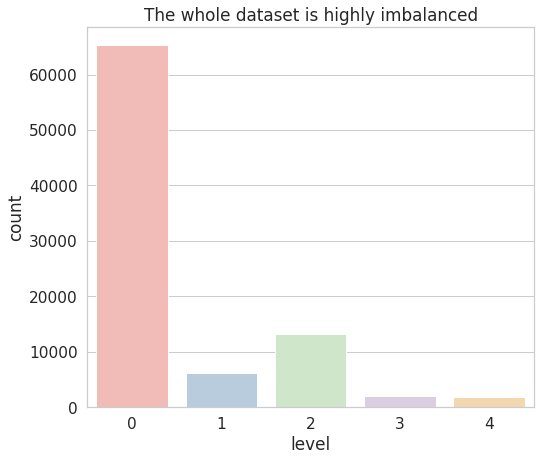

In [188]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.set_style("whitegrid")
sns.countplot(x='level', data=temp, palette='Pastel1', ax=ax)
plt.title('The whole dataset is highly imbalanced');

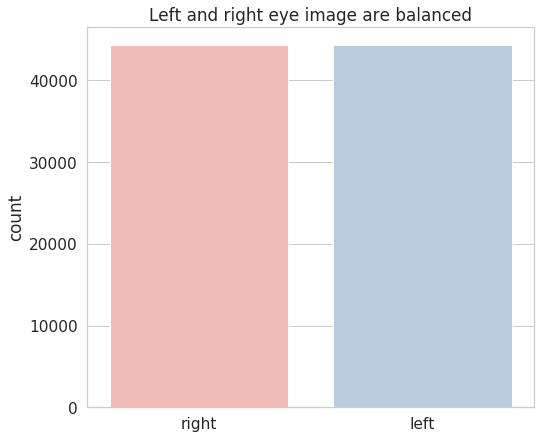

In [191]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.set_style("whitegrid")
sns.countplot(x='left', data=temp, palette='Pastel1', ax=ax)
ax.set_xticklabels(['right', 'left'])
ax.set_xlabel('')
plt.title('Left and right eye image are balanced');

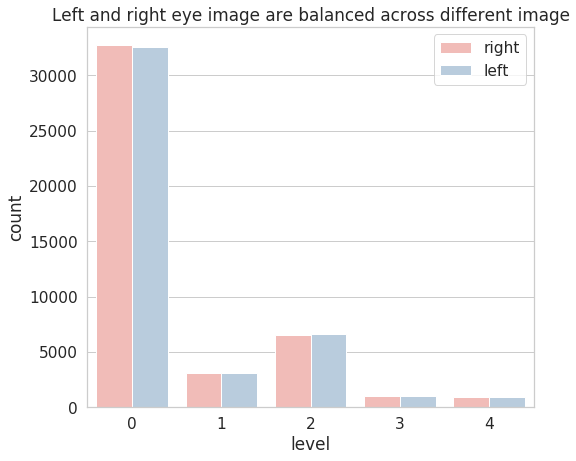

In [193]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.set_style("whitegrid")
sns.countplot(x='level', hue='left', data=temp, palette='Pastel1', ax=ax)
ax.legend(['right', 'left'])
plt.title('Left and right eye image are balanced across different levels');

In [194]:
del temp

### Create Generator

Create a data generator to get batches from train data.

In [76]:
def data_generator(captions, data, batch_size):
    """
    Create a generator that for 2 inputs (image vector, caption sequence)
    output is the next word in the sequence

    Parameters
    ----------
        captions : dict
            image filename as key and level as value
        data : dask bag
            image filaname as key and vectors from convolutional base as value
        img_map : list or iterator
            list or iterator to include, exclude data not in the img_map
        batch_size : int
            batch_size
    
    Returns
    -------
        result : 2 tuples
            first element is the 2 inputs image vector from the convolutional
            base and text to sequence of the caption
            second element is the output is the next word in the sequence
            ([image_vector, sequence], next_word)
    """
    x, y = [], []
    n = 0
    while 1:
        for image_name, vector in data.items():
            # Get image vector based on the convolutional base
            target = captions[image_name]
            # Set the value of target to binary
            target = to_categorical([target], num_classes=5)[0]
            x.append(vector)
            y.append(target)
            n += 1
            if n == batch_size:
                yield np.array(x), np.array(y)
                x, y = [], []
                n = 0

### Read data using Dask Bag

In [74]:
def join_dict(x, y):
    """Update dictionary x with values of dictionary y"""
    x.update(y)
    return x

In [145]:
# Read training extracted training data of different base
xception_data = (db.read_text(os.path.join('s3://', BUCKET,
                                        XCEPTION_VECTOR_PATH,
                                        '*.json'),
                           storage_options=settings_aws)
              .map(json.loads)
              .flatten()
              .persist())


inception_data = (db.read_text(os.path.join('s3://', BUCKET,
                                        INCEPTION_VECTOR_PATH,
                                        '*.json'),
                           storage_options=settings_aws)
              .map(json.loads)
              .flatten()
              .persist())



vgg_data = (db.read_text(os.path.join('s3://', BUCKET,
                                        VGG_VECTOR_PATH,
                                        '*.json'),
                           storage_options=settings_aws)
              .map(json.loads)
              .flatten()
              .persist())

# Data Preprocessing

This section preprocessed the image to mitigate the bias of the dataset towards the level 0 class. The dataset is split into three sets, namely, training, validation and test dataset. To balance frequency of classes in the dataset, the group performed undersampling and oversampling.

### Split dataset 60 20 20

In [22]:
x_train, x_test, y_train, y_test = train_test_split(all_labels.image,
                                                    all_labels.level,
                                                    test_size=0.2,
                                                    random_state=2021)
train_labels = all_labels.loc[all_labels.image.isin(x_train)]
x_train, x_val, y_train, y_val = train_test_split(train_labels.image,
                                                  train_labels.level,
                                                  test_size=0.25,
                                                  random_state=2021)

del all_labels, train_labels

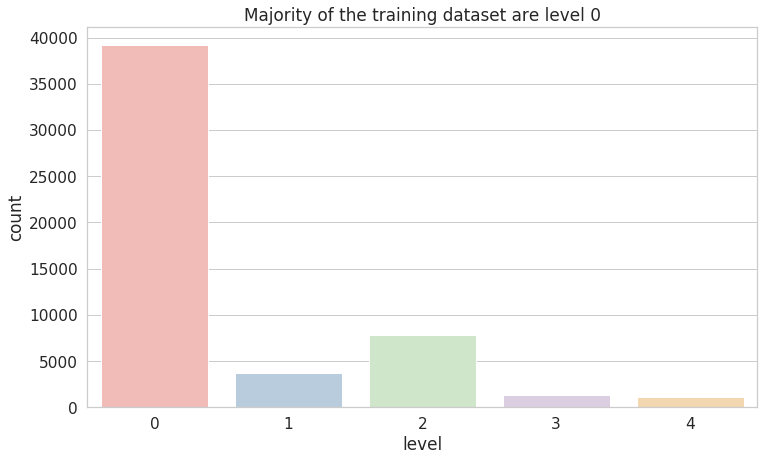

In [195]:
plt.figure(figsize=(12, 7))
sns.countplot(y_train, palette='Pastel1');
plt.title('Majority of the training dataset are level 0');

In [64]:
print('Without sampling Pcc:')
calculate_pcc(y_train)

Without sampling Pcc:
Pcc : 57.07%
Accuracy (1.25Pcc) required : 71.33%


### Perform sampling to solve imbalance data

#### Undersampling dataset

In [52]:
n_samples = int(y_train.value_counts().min())
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
new_x_train, new_y_train = pd.Series(dtype='object'), pd.Series(dtype='int32')
for cls in y_train.unique():
    idx = y_train[y_train==cls].index
    x = x_train.loc[idx]
    y = y_train.loc[idx]
    
    new_x, new_y = resample(x, y, replace=True, n_samples=n_samples,
                            random_state=2021)
    new_x_train = new_x_train.append(new_x)
    new_y_train = new_y_train.append(new_y)

x_train_under, y_train_under = new_x_train, new_y_train
del new_x_train, new_y_train

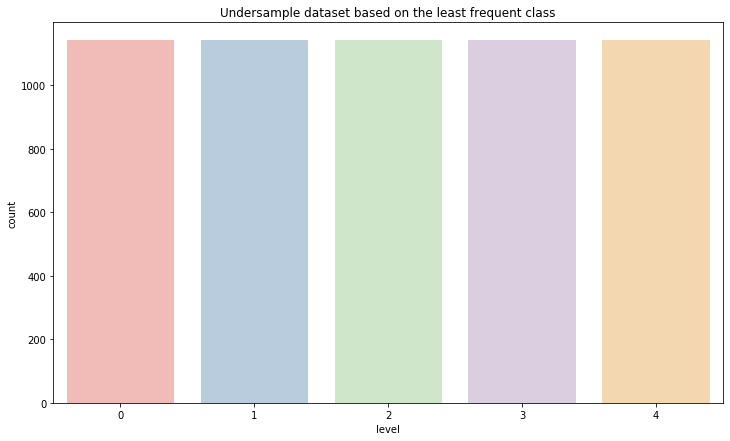

In [138]:
plt.figure(figsize=(12, 7))
sns.countplot(y_train_under, palette='Pastel1')
plt.xlabel('level')
plt.title('Undersample dataset based on the least frequent class');

In [66]:
print('Undersampling Pcc:')
calculate_pcc(y_train_under)

Undersampling Pcc:
Pcc : 20.00%
Accuracy (1.25Pcc) required : 25.00%


#### Oversampling dataset

In [54]:
n_samples = int(y_train.value_counts().max())
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
new_x_train, new_y_train = pd.Series(dtype='object'), pd.Series(dtype='int32')
for cls in y_train.unique():
    idx = y_train[y_train==cls].index
    x = x_train.loc[idx]
    y = y_train.loc[idx]
    
    new_x, new_y = resample(x, y, replace=True, n_samples=n_samples,
                            random_state=2021)
    new_x_train = new_x_train.append(new_x)
    new_y_train = new_y_train.append(new_y)

x_train_over, y_train_over = new_x_train, new_y_train
del new_x_train, new_y_train

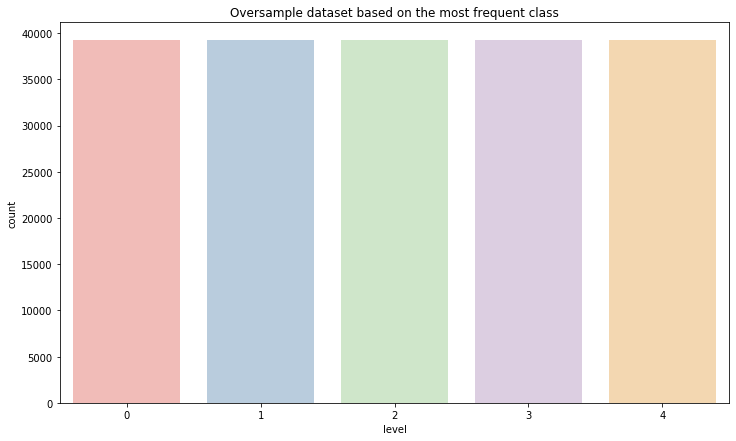

In [137]:
plt.figure(figsize=(12, 7))
sns.countplot(y_train_over, palette='Pastel1')
plt.xlabel('level')
plt.title('Oversample dataset based on the most frequent class');

In [67]:
print('Oversampling Pcc:')
calculate_pcc(y_train_over)

Oversampling Pcc:
Pcc : 20.00%
Accuracy (1.25Pcc) required : 25.00%


### Create map for image vectors and target

In [80]:
# Make train labels to dictionary for easier implementation
train_labels = pd.Series(y_train.values, index=x_train.values).to_dict()

# Undersample
train_labels_under = pd.Series(y_train_under.values,
                               index=x_train_under.values).to_dict()

# Oversample
train_labels_over = pd.Series(y_train_over.values,
                               index=x_train_over.values).to_dict()


val_labels = pd.Series(y_val.values, index=x_val.values).to_dict()
test_labels = pd.Series(y_test.values, index=x_test.values).to_dict()

# Model Selection

In this section we are goind to evaluate the Xception, InceptionResNetV2 and VGG16 convolutional base using the undersampled dataset.

In [84]:
def create_toplayers(base):
    """Create top layer using convolutional base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))
    
    # Add Dense
    lyr_dense1 = Dense(254, activation='relu')(lyr_input)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense1)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

Reduce the learning rate as the validation forms a plateau to ensure optimal weights for convergence.

In [97]:
reduceLROnPlat = ReduceLROnPlateau(monitor='val_accuracy',
                                   factor=0.7,
                                   patience=3,
                                   cooldown=3,
                                   verbose=0,
                                   min_lr=0.0001)


early = EarlyStopping(monitor="val_accuracy", 
                      verbose=1,
                      patience=30)

Set steps per epoch based on batch size.

In [81]:
batch_size = 1024
train_steps = len(train_labels_under) // batch_size
val_steps = len(val_labels) // batch_size
test_steps = (len_labels)

## Xception

### Get image vectors of undersample dataset

In [82]:
train_data_under = (xception_data.filter(lambda x: x['name'] in
                                         x_train_under.values)
                    .map(lambda x: {x['name']: np.asarray(x['value'])})
                    .fold(binop=lambda x, y: join_dict(x, y),
                          combine=lambda x, y: join_dict(x, y))
                    .compute())

In [90]:
val_data = (xception_data.filter(lambda x: x['name'] in x_val.values)
            .map(lambda x: {x['name']: np.asarray(x['value'])})
            .fold(binop=lambda x, y: join_dict(x, y),
                  combine=lambda x, y: join_dict(x, y))
            .compute())

### Build and train model

In [98]:
train_gen = data_generator(train_labels_under, train_data_under, batch_size)
val_gen = data_generator(val_labels, val_data, batch_size)

model_fp = 'tune/xception_base_under.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=0, save_best_only=True)
base = create_xception_base()
model = create_toplayers(base)
model.fit(train_gen,
          steps_per_epoch=train_steps,
          validation_data=val_gen,
          validation_steps=val_steps,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early],
          verbose=0
          )

Epoch 00032: early stopping


### Evaluate the result

In [99]:
# Evaluate validation dataset
model = load_model(model_fp)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

res = model.evaluate(train_gen, steps=train_steps)
print('Train loss: {} Train accuracy: {}'.format(*res))
# Evaluate validation dataset
res = model.evaluate(val_gen, steps=val_steps)
print('Validation loss: {} Validation accuracy: {}'.format(*res))

del res

4/4 [==============================] - 0s 21ms/step - loss: 1.4597 - accuracy: 0.3116
Train loss: 1.4594099521636963 Train accuracy: 0.312744140625
17/17 [==============================] - 0s 20ms/step - loss: 1.2087 - accuracy: 0.6307
Validation loss: 1.2086825370788574 Validation accuracy: 0.6306870579719543


## InceptionResNet V2

### Get image vectors of undersample dataset

In [100]:
train_data_under = (inception_data.filter(lambda x: x['name'] in
                                         x_train_under.values)
                    .map(lambda x: {x['name']: np.asarray(x['value'])})
                    .fold(binop=lambda x, y: join_dict(x, y),
                          combine=lambda x, y: join_dict(x, y))
                    .compute())

In [101]:
val_data = (inception_data.filter(lambda x: x['name'] in x_val.values)
            .map(lambda x: {x['name']: np.asarray(x['value'])})
            .fold(binop=lambda x, y: join_dict(x, y),
                  combine=lambda x, y: join_dict(x, y))
            .compute())

### Build and train model

In [105]:
train_gen = data_generator(train_labels_under, train_data_under, batch_size)
val_gen = data_generator(val_labels, val_data, batch_size)

model_fp = 'tune/inceptionresnet_base_under.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=0, save_best_only=True)
base = create_inceptionresnet_base()
model = create_toplayers(base)
model.fit(train_gen,
          steps_per_epoch=train_steps,
          validation_data = val_gen,
          validation_steps = val_steps,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early],
          verbose=0)

Epoch 00035: early stopping


### Evaluate the result

In [106]:
# Evaluate validation dataset
model = load_model(model_fp)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

res = model.evaluate(train_gen, steps=train_steps)
print('Train loss: {} Train accuracy: {}'.format(*res))
# Evaluate validation dataset
res = model.evaluate(val_gen, steps=val_steps)
print('Validation loss: {} Validation accuracy: {}'.format(*res))

del res

4/4 [==============================] - 0s 19ms/step - loss: 1.3616 - accuracy: 0.3860
Train loss: 1.3631861209869385 Train accuracy: 0.38916015625
17/17 [==============================] - 0s 19ms/step - loss: 1.2418 - accuracy: 0.5681
Validation loss: 1.2418025732040405 Validation accuracy: 0.5680721402168274


## VGG 16

### Get image vectors of undersample dataset

In [119]:
train_data_under = (vgg_data.filter(lambda x: x['name'] in
                                         x_train_under.values)
                    .map(lambda x: {x['name']: np.asarray(x['value'])})
                    .fold(binop=lambda x, y: join_dict(x, y),
                          combine=lambda x, y: join_dict(x, y))
                    .compute())

In [120]:
val_data = (vgg_data.filter(lambda x: x['name'] in x_val.values)
            .map(lambda x: {x['name']: np.asarray(x['value'])})
            .fold(binop=lambda x, y: join_dict(x, y),
                  combine=lambda x, y: join_dict(x, y))
            .compute())

### Build and train model

In [122]:
train_gen = data_generator(train_labels_under, train_data_under, batch_size)
val_gen = data_generator(val_labels, val_data, batch_size)

model_fp = 'tune/vgg_base_under.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=0, save_best_only=True)
base = create_vgg_base()
model = create_toplayers(base)
model.fit(train_gen,
          steps_per_epoch=train_steps,
          validation_data = val_gen,
          validation_steps = val_steps,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early],
          verbose=0)

Epoch 00032: early stopping


### Evaluate the result

In [123]:
# Evaluate validation dataset
model = load_model(model_fp)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

res = model.evaluate(train_gen, steps=train_steps)
print('Train loss: {} Train accuracy: {}'.format(*res))
# Evaluate validation dataset
res = model.evaluate(val_gen, steps=val_steps)
print('Validation loss: {} Validation accuracy: {}'.format(*res))

del res

4/4 [==============================] - 0s 17ms/step - loss: 1.6430 - accuracy: 0.2398
Train loss: 1.6418166160583496 Train accuracy: 0.241455078125
17/17 [==============================] - 0s 16ms/step - loss: 1.1426 - accuracy: 0.7385
Validation loss: 1.142638921737671 Validation accuracy: 0.7384535670280457


## Result of evaluation

After evaluation the three different convolutional base performance, the group observed that all of the model exhibits underfitting. The all training accuracy is below 40%, while the validation accuracy is greater than 56%. From the results, the InceptionResNet-V2 got the highest training accuracy of 38.92%, whereas the VGG16 got the highest validation accuracy of 73.84%. The group choose the InceptionResNet-V2 model since it has a lower case of underfitting compared to the other models.

|   	| Base               	| Train % 	| Validation % 	|
|---	|--------------------	|---------	|--------------	|
| 1 	| Xception           	| 31.27   	| 63.06        	|
| 2 	| InceptionResNet-V2 	| 38.92   	| 56.81        	|
| 3 	| VGG16              	| 24.14   	| 73.84        	|

# Fine Tuning

After selecting the best convolutional base, this section simulates different variantions of the selected base model, InceptionResNet-V2.

In [125]:
base = create_inceptionresnet_base()

In [153]:
def evaluate(y_true, y_pred):
    """Calculate and print the accuracy, confusion matrix, and precision"""
    print('Accuracy:', metrics.accuracy_score(y_true, y_pred))
    print('Classification Report')
    print(metrics.classification_report(y_true, y_pred, digits=3,
                                        labels=np.unique(y_true)))
    # Display Confusion matrix
    conf = metrics.confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(conf)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm.applymap(int), annot=True, fmt='g') # font size
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.show()

    del df_cm, conf

In [101]:
val_data = (inception_data.filter(lambda x: x['name'] in x_val.values)
            .map(lambda x: {x['name']: np.asarray(x['value'])})
            .fold(binop=lambda x, y: join_dict(x, y),
                  combine=lambda x, y: join_dict(x, y))
            .compute())

In [129]:
val = [[vector, val_labels[img_fn]] for img_fn, vector in val_data.items()]
x_val_vec = np.array(list(map(lambda x: x[0], val)))
y_val_true = list(map(lambda x: x[1], val))

y_val_bin = np.array(
    list(map(lambda x: to_categorical([x], num_classes=5)[0], y_val_true)))
del val

## Oversampled Training Dataset

This simulation used the oversampled dataset of the diabetic retinopathy dataset.

In [100]:
train_data_over = (inception_data.filter(lambda x: x['name'] in
                                         x_train_over.values)
                    .map(lambda x: {x['name']: np.asarray(x['value'])})
                    .fold(binop=lambda x, y: join_dict(x, y),
                          combine=lambda x, y: join_dict(x, y))
                    .compute())

### Add Dropout and Dense Layer

In [30]:
def create_toplayers(base):
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add dropout layer
    lyr_dropout1 = Dropout(0.25)(lyr_input)
    # Add Dense
    lyr_dense1 = Dense(254, activation='relu')(lyr_dropout1)
    # Add dropout layer
    lyr_dropout2 = Dropout(0.25)(lyr_dense1)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dropout2)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [31]:
batch_size = 1024
train_gen = data_generator(train_labels_over, train_data_over, batch_size)
val_gen = data_generator(val_labels, val_data, batch_size)
train_steps = len(train_labels_over) // batch_size
val_steps = len(val_labels) // batch_size

In [32]:
model_fp = 'tune/resample_base.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [35]:
model = create_toplayers(base)
model.fit(train_gen,
          steps_per_epoch=train_steps,
          validation_data = val_gen,
          validation_steps = val_steps,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
37/37 [==============================] - 3s 34ms/step - loss: 1.1484 - accuracy: 0.5980 - val_loss: 0.8357 - val_accuracy: 0.7361

Epoch 00001: val_accuracy improved from -inf to 0.73610, saving model to tune/resample_base.h5
Epoch 2/200
37/37 [==============================] - 1s 29ms/step - loss: 0.9884 - accuracy: 0.6391 - val_loss: 0.8196 - val_accuracy: 0.7363

Epoch 00002: val_accuracy improved from 0.73610 to 0.73633, saving model to tune/resample_base.h5
Epoch 3/200
37/37 [==============================] - 1s 29ms/step - loss: 0.9541 - accuracy: 0.6441 - val_loss: 0.7936 - val_accuracy: 0.7412

Epoch 00003: val_accuracy improved from 0.73633 to 0.74121, saving model to tune/resample_base.h5
Epoch 4/200
37/37 [==============================] - 1s 29ms/step - loss: 0.9369 - accuracy: 0.6490 - val_loss: 0.7738 - val_accuracy: 0.7451

Epoch 00004: val_accuracy improved from 0.74121 to 0.74512, saving model to tune/resample_base.h5
Epoch 5/200
37/37 [====================

37/37 [==============================] - 1s 29ms/step - loss: 0.8562 - accuracy: 0.6794 - val_loss: 0.7081 - val_accuracy: 0.7686

Epoch 00037: val_accuracy did not improve from 0.76930
Epoch 38/200
37/37 [==============================] - 1s 29ms/step - loss: 0.8487 - accuracy: 0.6808 - val_loss: 0.7087 - val_accuracy: 0.7691

Epoch 00038: val_accuracy did not improve from 0.76930
Epoch 39/200
37/37 [==============================] - 1s 29ms/step - loss: 0.8550 - accuracy: 0.6834 - val_loss: 0.7077 - val_accuracy: 0.7687

Epoch 00039: val_accuracy did not improve from 0.76930

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.00024009999469853935.
Epoch 40/200
37/37 [==============================] - 1s 29ms/step - loss: 0.8513 - accuracy: 0.6828 - val_loss: 0.6973 - val_accuracy: 0.7688

Epoch 00040: val_accuracy did not improve from 0.76930
Epoch 41/200
37/37 [==============================] - 1s 28ms/step - loss: 0.8527 - accuracy: 0.6830 - val_loss: 0.6982 - val_accuracy:

37/37 [==============================] - 1s 29ms/step - loss: 0.8308 - accuracy: 0.6919 - val_loss: 0.6975 - val_accuracy: 0.7728

Epoch 00116: val_accuracy did not improve from 0.77344
Epoch 117/200
37/37 [==============================] - 1s 29ms/step - loss: 0.8341 - accuracy: 0.6899 - val_loss: 0.6947 - val_accuracy: 0.7734

Epoch 00117: val_accuracy did not improve from 0.77344
Epoch 118/200
37/37 [==============================] - 1s 29ms/step - loss: 0.8348 - accuracy: 0.6920 - val_loss: 0.6947 - val_accuracy: 0.7733

Epoch 00118: val_accuracy did not improve from 0.77344
Epoch 119/200
37/37 [==============================] - 1s 29ms/step - loss: 0.8357 - accuracy: 0.6885 - val_loss: 0.6921 - val_accuracy: 0.7741

Epoch 00119: val_accuracy improved from 0.77344 to 0.77413, saving model to tune/resample_base.h5
Epoch 120/200
37/37 [==============================] - 1s 29ms/step - loss: 0.8343 - accuracy: 0.6894 - val_loss: 0.6926 - val_accuracy: 0.7726

Epoch 00120: val_accuracy 

In [137]:
model = load_model('tune/resample_base.h5')


In [237]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7739753058578114
Classification Report
              precision    recall  f1-score   support

           0      0.802     0.970     0.878     13063
           1      0.000     0.000     0.000      1252
           2      0.541     0.300     0.386      2677
           3      0.530     0.211     0.302       375
           4      0.556     0.457     0.501       370

    accuracy                          0.774     17737
   macro avg      0.486     0.388     0.413     17737
weighted avg      0.695     0.774     0.722     17737



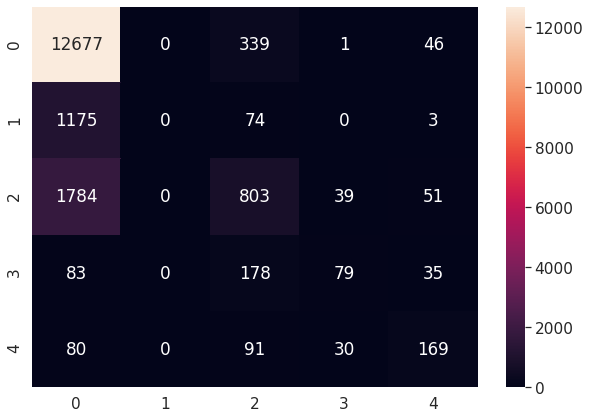

In [274]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Replace Dropout with Dense

In [368]:
def create_toplayers(base):
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense3)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [369]:
batch_size = 1024
train_gen = data_generator(train_labels_over, train_data_over, batch_size)
val_gen = data_generator(val_labels, val_data, batch_size)
train_steps = len(train_labels_over) // batch_size
val_steps = len(val_labels) // batch_size

In [370]:
model_fp = 'tune/resample_dropToDense.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [371]:
model = create_toplayers(base)
model.fit(train_gen,
          steps_per_epoch=train_steps,
          validation_data = val_gen,
          validation_steps = val_steps,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
37/37 [==============================] - 1s 30ms/step - loss: 1.1157 - accuracy: 0.5736 - val_loss: 0.7984 - val_accuracy: 0.7337

Epoch 00001: val_accuracy improved from -inf to 0.73374, saving model to tune/resample_dropToDense.h5
Epoch 2/200
37/37 [==============================] - 1s 27ms/step - loss: 0.9427 - accuracy: 0.6468 - val_loss: 0.7518 - val_accuracy: 0.7441

Epoch 00002: val_accuracy improved from 0.73374 to 0.74408, saving model to tune/resample_dropToDense.h5
Epoch 3/200
37/37 [==============================] - 1s 26ms/step - loss: 0.9010 - accuracy: 0.6605 - val_loss: 0.7667 - val_accuracy: 0.7388

Epoch 00003: val_accuracy did not improve from 0.74408
Epoch 4/200
37/37 [==============================] - 1s 27ms/step - loss: 0.8793 - accuracy: 0.6676 - val_loss: 0.7419 - val_accuracy: 0.7538

Epoch 00004: val_accuracy improved from 0.74408 to 0.75379, saving model to tune/resample_dropToDense.h5
Epoch 5/200
37/37 [==============================] - 1s 27ms/

37/37 [==============================] - 1s 27ms/step - loss: 0.6610 - accuracy: 0.7600 - val_loss: 0.6590 - val_accuracy: 0.7741

Epoch 00079: val_accuracy did not improve from 0.79102
Epoch 80/200
37/37 [==============================] - 1s 27ms/step - loss: 0.6582 - accuracy: 0.7621 - val_loss: 0.6760 - val_accuracy: 0.7649

Epoch 00080: val_accuracy did not improve from 0.79102


In [373]:
model = load_model('tune/resample_dropToDense.h5')
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7903253086767773
Classification Report
              precision    recall  f1-score   support

           0      0.825     0.966     0.890     13063
           1      1.000     0.001     0.002      1252
           2      0.580     0.406     0.478      2677
           3      0.457     0.371     0.409       375
           4      0.646     0.478     0.550       370

    accuracy                          0.790     17737
   macro avg      0.702     0.444     0.466     17737
weighted avg      0.789     0.790     0.748     17737



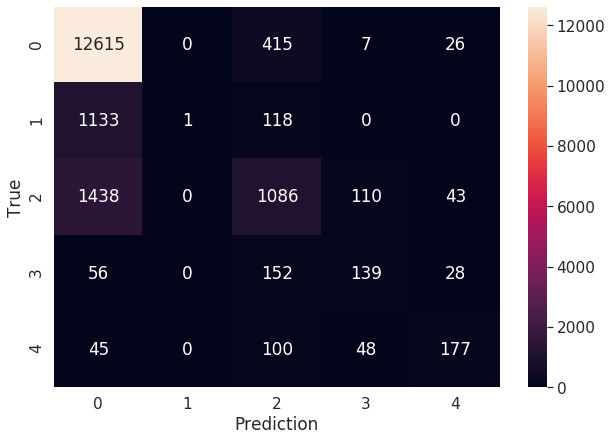

In [374]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Replace Dropout with Dense, add weights

In [382]:
def create_toplayers(base):
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense3)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [383]:
batch_size = 1024
train_gen = data_generator(train_labels_over, train_data_over, batch_size)
val_gen = data_generator(val_labels, val_data, batch_size)
train_steps = len(train_labels_over) // batch_size
val_steps = len(val_labels) // batch_size

In [384]:
model_fp = 'tune/resample_dropToDense_weighted.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [385]:
model = create_toplayers(base)
model.fit(train_gen,
          steps_per_epoch=train_steps,
          validation_data = val_gen,
          validation_steps = val_steps,
          epochs=200,
          class_weight={0:1, 1:8, 2:2, 3:2, 4:4},
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
37/37 [==============================] - 1s 30ms/step - loss: 2.7109 - accuracy: 0.2611 - val_loss: 1.1311 - val_accuracy: 0.3641

Epoch 00001: val_accuracy improved from -inf to 0.36414, saving model to tune/resample_dropToDense_weighted.h5
Epoch 2/200
37/37 [==============================] - 1s 27ms/step - loss: 2.3536 - accuracy: 0.3142 - val_loss: 1.0528 - val_accuracy: 0.5363

Epoch 00002: val_accuracy improved from 0.36414 to 0.53631, saving model to tune/resample_dropToDense_weighted.h5
Epoch 3/200
37/37 [==============================] - 1s 26ms/step - loss: 2.2532 - accuracy: 0.3812 - val_loss: 1.1971 - val_accuracy: 0.2360

Epoch 00003: val_accuracy did not improve from 0.53631
Epoch 4/200
37/37 [==============================] - 1s 27ms/step - loss: 2.2093 - accuracy: 0.3916 - val_loss: 1.2726 - val_accuracy: 0.1750

Epoch 00004: val_accuracy did not improve from 0.53631
Epoch 5/200
37/37 [==============================] - 1s 27ms/step - loss: 2.1891 - accuracy: 

In [386]:
model = load_model('tune/resample_dropToDense_weighted.h5')
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.6837120144331059
Classification Report
              precision    recall  f1-score   support

           0      0.841     0.822     0.831     13063
           1      0.123     0.284     0.172      1252
           2      0.513     0.285     0.366      2677
           3      0.556     0.147     0.232       375
           4      0.431     0.584     0.496       370

    accuracy                          0.684     17737
   macro avg      0.493     0.424     0.419     17737
weighted avg      0.726     0.684     0.695     17737



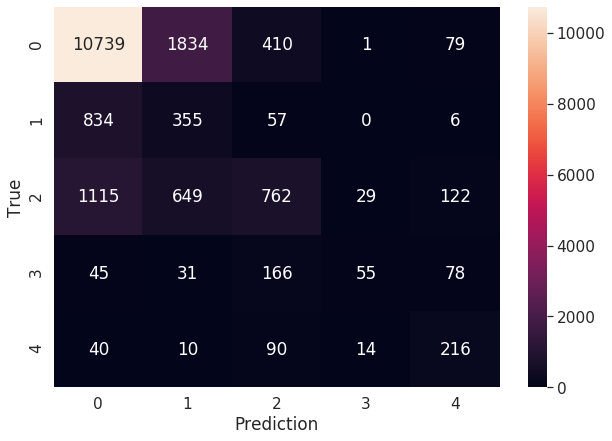

In [387]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Add more Dense

In [414]:
def create_toplayers(base):
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)
    lyr_dense4 = Dense(128, activation='relu')(lyr_dense3)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense4)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [415]:
batch_size = 1024
train_gen = data_generator(train_labels_over, train_data_over, batch_size)
val_gen = data_generator(val_labels, val_data, batch_size)
train_steps = len(train_labels_over) // batch_size
val_steps = len(val_labels) // batch_size

In [416]:
model_fp = 'tune/resample_moreDense.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [417]:
model = create_toplayers(base)
model.fit(train_gen,
          steps_per_epoch=train_steps,
          validation_data = val_gen,
          validation_steps = val_steps,
          epochs=200,
#           class_weight={0:1, 1:11, 2:2, 3:2, 4:3},
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
37/37 [==============================] - 1s 30ms/step - loss: 1.1631 - accuracy: 0.5812 - val_loss: 0.8174 - val_accuracy: 0.7337

Epoch 00001: val_accuracy improved from -inf to 0.73374, saving model to tune/resample_moreDense.h5
Epoch 2/200
37/37 [==============================] - 1s 26ms/step - loss: 0.9550 - accuracy: 0.6404 - val_loss: 0.7648 - val_accuracy: 0.7386

Epoch 00002: val_accuracy improved from 0.73374 to 0.73857, saving model to tune/resample_moreDense.h5
Epoch 3/200
37/37 [==============================] - 1s 26ms/step - loss: 0.9043 - accuracy: 0.6570 - val_loss: 0.7480 - val_accuracy: 0.7496

Epoch 00003: val_accuracy improved from 0.73857 to 0.74960, saving model to tune/resample_moreDense.h5
Epoch 4/200
37/37 [==============================] - 1s 26ms/step - loss: 0.8784 - accuracy: 0.6683 - val_loss: 0.7572 - val_accuracy: 0.7509

Epoch 00004: val_accuracy improved from 0.74960 to 0.75092, saving model to tune/resample_moreDense.h5
Epoch 5/200
37/37 [

37/37 [==============================] - 1s 26ms/step - loss: 0.6299 - accuracy: 0.7720 - val_loss: 0.6451 - val_accuracy: 0.7872

Epoch 00078: val_accuracy did not improve from 0.79383
Epoch 79/200
37/37 [==============================] - 1s 26ms/step - loss: 0.6269 - accuracy: 0.7738 - val_loss: 0.6527 - val_accuracy: 0.7824

Epoch 00079: val_accuracy did not improve from 0.79383
Epoch 80/200
37/37 [==============================] - 1s 27ms/step - loss: 0.6216 - accuracy: 0.7783 - val_loss: 0.6650 - val_accuracy: 0.7759

Epoch 00080: val_accuracy did not improve from 0.79383
Epoch 81/200
37/37 [==============================] - 1s 26ms/step - loss: 0.6221 - accuracy: 0.7783 - val_loss: 0.6698 - val_accuracy: 0.7731

Epoch 00081: val_accuracy did not improve from 0.79383
Epoch 82/200
37/37 [==============================] - 1s 27ms/step - loss: 0.6174 - accuracy: 0.7797 - val_loss: 0.6706 - val_accuracy: 0.7740

Epoch 00082: val_accuracy did not improve from 0.79383
Epoch 83/200
37/37

In [418]:
model = load_model('tune/resample_moreDense.h5')
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7934825506004397
Classification Report
              precision    recall  f1-score   support

           0      0.829     0.965     0.892     13063
           1      0.667     0.002     0.003      1252
           2      0.586     0.443     0.505      2677
           3      0.461     0.331     0.385       375
           4      0.686     0.408     0.512       370

    accuracy                          0.793     17737
   macro avg      0.646     0.430     0.459     17737
weighted avg      0.770     0.793     0.752     17737



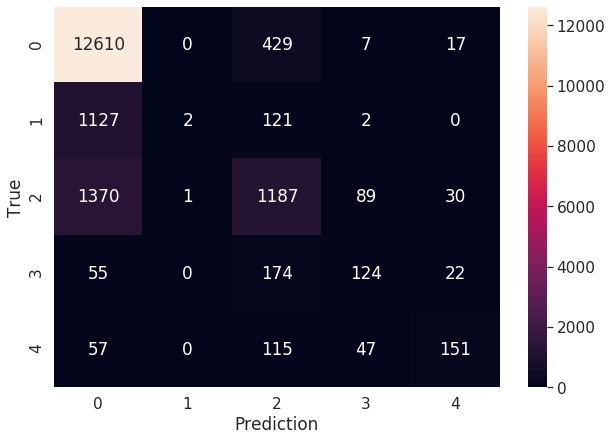

In [419]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Add more Dense with Bias

In [420]:
def create_toplayers(base):
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu',
                       bias_initializer='ones')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)
    lyr_dense4 = Dense(128, activation='relu')(lyr_dense3)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense4)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [421]:
batch_size = 1024
train_gen = data_generator(train_labels_over, train_data_over, batch_size)
val_gen = data_generator(val_labels, val_data, batch_size)
train_steps = len(train_labels_over) // batch_size
val_steps = len(val_labels) // batch_size

In [422]:
model_fp = 'tune/resample_moreDense_bias.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [423]:
model = create_toplayers(base)
model.fit(train_gen,
          steps_per_epoch=train_steps,
          validation_data = val_gen,
          validation_steps = val_steps,
          epochs=200,
#           class_weight={0:1, 1:11, 2:2, 3:2, 4:3},
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
37/37 [==============================] - 1s 30ms/step - loss: 1.4694 - accuracy: 0.6113 - val_loss: 0.8405 - val_accuracy: 0.7367

Epoch 00001: val_accuracy improved from -inf to 0.73667, saving model to tune/resample_moreDense_bias.h5
Epoch 2/200
37/37 [==============================] - 1s 26ms/step - loss: 1.0089 - accuracy: 0.6388 - val_loss: 0.7873 - val_accuracy: 0.7336

Epoch 00002: val_accuracy did not improve from 0.73667
Epoch 3/200
37/37 [==============================] - 1s 26ms/step - loss: 0.9340 - accuracy: 0.6481 - val_loss: 0.7507 - val_accuracy: 0.7432

Epoch 00003: val_accuracy improved from 0.73667 to 0.74316, saving model to tune/resample_moreDense_bias.h5
Epoch 4/200
37/37 [==============================] - 1s 26ms/step - loss: 0.9021 - accuracy: 0.6581 - val_loss: 0.7795 - val_accuracy: 0.7416

Epoch 00004: val_accuracy did not improve from 0.74316
Epoch 5/200
37/37 [==============================] - 1s 26ms/step - loss: 0.8866 - accuracy: 0.6636 - val

37/37 [==============================] - 1s 27ms/step - loss: 0.7341 - accuracy: 0.7305 - val_loss: 0.6526 - val_accuracy: 0.7811

Epoch 00039: val_accuracy did not improve from 0.78470
Epoch 40/200
37/37 [==============================] - 1s 26ms/step - loss: 0.7313 - accuracy: 0.7322 - val_loss: 0.6477 - val_accuracy: 0.7844

Epoch 00040: val_accuracy did not improve from 0.78470
Epoch 41/200
37/37 [==============================] - 1s 26ms/step - loss: 0.7336 - accuracy: 0.7292 - val_loss: 0.6503 - val_accuracy: 0.7830

Epoch 00041: val_accuracy did not improve from 0.78470
Epoch 42/200
37/37 [==============================] - 1s 27ms/step - loss: 0.7309 - accuracy: 0.7333 - val_loss: 0.6781 - val_accuracy: 0.7696

Epoch 00042: val_accuracy did not improve from 0.78470
Epoch 43/200
37/37 [==============================] - 1s 26ms/step - loss: 0.7238 - accuracy: 0.7359 - val_loss: 0.6382 - val_accuracy: 0.7858

Epoch 00043: val_accuracy improved from 0.78470 to 0.78579, saving model 


Epoch 00119: val_accuracy did not improve from 0.78935
Epoch 120/200
37/37 [==============================] - 1s 27ms/step - loss: 0.6335 - accuracy: 0.7710 - val_loss: 0.6802 - val_accuracy: 0.7649

Epoch 00120: val_accuracy did not improve from 0.78935
Epoch 121/200
37/37 [==============================] - 1s 27ms/step - loss: 0.6328 - accuracy: 0.7716 - val_loss: 0.6479 - val_accuracy: 0.7842

Epoch 00121: val_accuracy did not improve from 0.78935
Epoch 122/200
37/37 [==============================] - 1s 27ms/step - loss: 0.6286 - accuracy: 0.7731 - val_loss: 0.6426 - val_accuracy: 0.7875

Epoch 00122: val_accuracy did not improve from 0.78935
Epoch 123/200
37/37 [==============================] - 1s 27ms/step - loss: 0.6254 - accuracy: 0.7740 - val_loss: 0.6493 - val_accuracy: 0.7849

Epoch 00123: val_accuracy did not improve from 0.78935
Epoch 124/200
37/37 [==============================] - 1s 27ms/step - loss: 0.6245 - accuracy: 0.7758 - val_loss: 0.6736 - val_accuracy: 0.7729


In [424]:
model = load_model('tune/resample_moreDense_bias.h5')
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7898178947961888
Classification Report
              precision    recall  f1-score   support

           0      0.825     0.964     0.889     13063
           1      0.250     0.002     0.005      1252
           2      0.562     0.436     0.491      2677
           3      0.556     0.213     0.308       375
           4      0.703     0.449     0.548       370

    accuracy                          0.790     17737
   macro avg      0.579     0.413     0.448     17737
weighted avg      0.736     0.790     0.747     17737



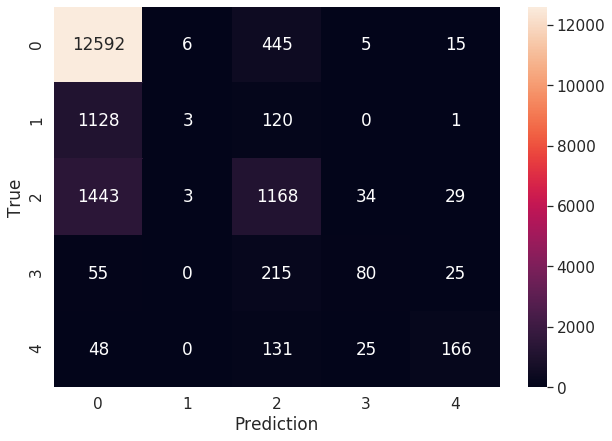

In [425]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Result of Oversampling and Fine Tuning

After simulating different network architectures, the group found that adding the more layers to the network without class weights and bias yields the best result. With a traning accuracy of 74.36% and validation accuracy of 79%. The model achieved a 78.9% precision and 79% recall.

## SMOTE Oversampling

Instead of sampling with replacement, use SMOTE to create sythetic data to oversample the minority classes.

In [127]:
train_data_sm = (inception_data.filter(lambda x: x['name'] in
                                       x_train.values)
                 .map(lambda x: {x['name']: np.asarray(x['value'])})
                 .fold(binop=lambda x, y: join_dict(x, y),
                       combine=lambda x, y: join_dict(x, y))
                 .compute())

In [130]:
train = [[vector, train_labels[img_fn]]
         for img_fn, vector in train_data_sm.items()]
x_train_vec = np.array(list(map(lambda x: x[0], train)))
y_train_true = list(map(lambda x: x[1], train))
del train

In [131]:
# Create SMOTE object to fit and sample the dataset
sm = SMOTE(random_state=1)
x_train_sm, y_train_sm = sm.fit_sample(x_train_vec, y_train_true)

In [132]:
x_train_sm = np.array(x_train_sm)
y_train_true = y_train_sm
y_train_sm = np.array(list(map(lambda x: to_categorical([x],
                                                        num_classes=5)[0],
                               y_train_sm)))

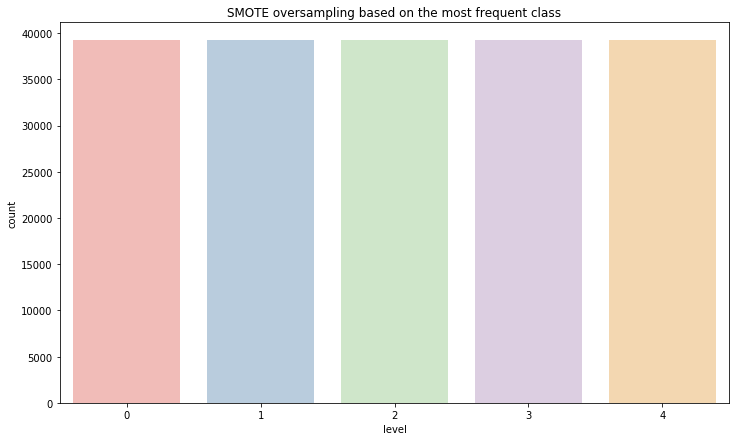

In [136]:
plt.figure(figsize=(12, 7))
sns.countplot(y_train_true, palette='Pastel1')
plt.xlabel('level')
plt.title('SMOTE oversampling based on the most frequent class');

### Base

In [36]:
def create_toplayers(base):
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add dropout layer
    lyr_dropout1 = Dropout(0.25)(lyr_input)
    # Add Dense
    lyr_dense1 = Dense(254, activation='relu')(lyr_dropout1)
    # Add dropout layer
    lyr_dropout2 = Dropout(0.25)(lyr_dense1)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dropout2)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [37]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [53]:
model_fp = 'tune/smote_base.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [60]:
model = create_toplayers()
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
191/191 [==============================] - 1s 5ms/step - loss: 1.3397 - accuracy: 0.3946 - val_loss: 1.1697 - val_accuracy: 0.4164

Epoch 00001: val_accuracy improved from -inf to 0.41642, saving model to tune/smote_base.h5
Epoch 2/200
191/191 [==============================] - 1s 4ms/step - loss: 1.1336 - accuracy: 0.4948 - val_loss: 1.2311 - val_accuracy: 0.3727

Epoch 00002: val_accuracy did not improve from 0.41642
Epoch 3/200
191/191 [==============================] - 1s 4ms/step - loss: 1.0947 - accuracy: 0.5160 - val_loss: 1.2314 - val_accuracy: 0.3154

Epoch 00003: val_accuracy did not improve from 0.41642
Epoch 4/200
191/191 [==============================] - 1s 4ms/step - loss: 1.0716 - accuracy: 0.5252 - val_loss: 1.1299 - val_accuracy: 0.4719

Epoch 00004: val_accuracy improved from 0.41642 to 0.47185, saving model to tune/smote_base.h5
Epoch 5/200
191/191 [==============================] - 1s 4ms/step - loss: 1.0569 - accuracy: 0.5343 - val_loss: 1.1783 - val_a

In [61]:
model = load_model('tune/smote_base.h5')

In [62]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.6117720020296555
Classification Report
              precision    recall  f1-score   support

           0      0.853     0.717     0.779     13063
           1      0.124     0.290     0.173      1252
           2      0.356     0.251     0.295      2677
           3      0.210     0.547     0.303       375
           4      0.263     0.676     0.378       370

    accuracy                          0.612     17737
   macro avg      0.361     0.496     0.386     17737
weighted avg      0.700     0.612     0.644     17737



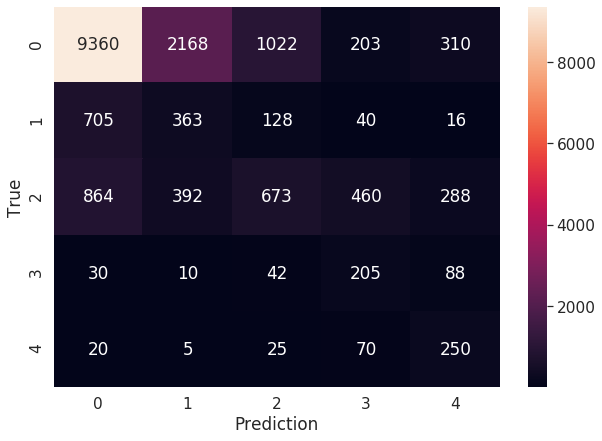

In [63]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Replace Dropout with Dense

In [69]:
def create_toplayers(base):
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense3)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [70]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [71]:
model_fp = 'tune/smote_dropToDense.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [72]:
model = create_toplayers()
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
191/191 [==============================] - 2s 7ms/step - loss: 1.2664 - accuracy: 0.4300 - val_loss: 1.0652 - val_accuracy: 0.5475

Epoch 00001: val_accuracy improved from -inf to 0.54751, saving model to tune/smote_dropToDense.h5
Epoch 2/200
191/191 [==============================] - 1s 5ms/step - loss: 0.9881 - accuracy: 0.5667 - val_loss: 1.1655 - val_accuracy: 0.4457

Epoch 00002: val_accuracy did not improve from 0.54751
Epoch 3/200
191/191 [==============================] - 1s 5ms/step - loss: 0.9299 - accuracy: 0.5916 - val_loss: 0.8915 - val_accuracy: 0.6303

Epoch 00003: val_accuracy improved from 0.54751 to 0.63034, saving model to tune/smote_dropToDense.h5
Epoch 4/200
191/191 [==============================] - 1s 5ms/step - loss: 0.8713 - accuracy: 0.6207 - val_loss: 0.9201 - val_accuracy: 0.5851

Epoch 00004: val_accuracy did not improve from 0.63034
Epoch 5/200
191/191 [==============================] - 1s 5ms/step - loss: 0.8118 - accuracy: 0.6505 - val_loss: 

191/191 [==============================] - 1s 6ms/step - loss: 0.1478 - accuracy: 0.9482 - val_loss: 1.2775 - val_accuracy: 0.6688

Epoch 00041: val_accuracy did not improve from 0.70824
Epoch 42/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1407 - accuracy: 0.9523 - val_loss: 1.2506 - val_accuracy: 0.6888

Epoch 00042: val_accuracy did not improve from 0.70824
Epoch 43/200
191/191 [==============================] - 1s 6ms/step - loss: 0.1416 - accuracy: 0.9511 - val_loss: 1.2602 - val_accuracy: 0.6903

Epoch 00043: val_accuracy did not improve from 0.70824
Epoch 44/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1338 - accuracy: 0.9548 - val_loss: 1.2701 - val_accuracy: 0.6935

Epoch 00044: val_accuracy did not improve from 0.70824
Epoch 45/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1322 - accuracy: 0.9545 - val_loss: 1.3139 - val_accuracy: 0.6692

Epoch 00045: val_accuracy did not improve from 0.70824
Epoch 46/200


In [73]:
model = load_model('tune/smote_dropToDense.h5')

In [74]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7340023679314428
Classification Report
              precision    recall  f1-score   support

           0      0.828     0.885     0.856     13063
           1      0.132     0.100     0.114      1252
           2      0.477     0.387     0.427      2677
           3      0.376     0.347     0.361       375
           4      0.533     0.457     0.492       370

    accuracy                          0.734     17737
   macro avg      0.469     0.435     0.450     17737
weighted avg      0.710     0.734     0.721     17737



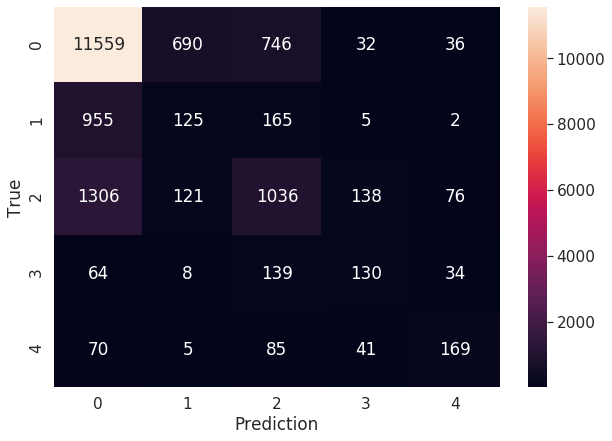

In [75]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Replace Dropout with Dense, add weights

In [77]:
def create_toplayers(base):
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense3)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [78]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [79]:
model_fp = 'tune/smote_dropToDense_weighted.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [80]:
model = create_toplayers(base)
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
191/191 [==============================] - 2s 8ms/step - loss: 1.2692 - accuracy: 0.4254 - val_loss: 1.0331 - val_accuracy: 0.5665

Epoch 00001: val_accuracy improved from -inf to 0.56646, saving model to tune/smote_dropToDense_weighted.h5
Epoch 2/200
191/191 [==============================] - 1s 5ms/step - loss: 0.9881 - accuracy: 0.5657 - val_loss: 1.1751 - val_accuracy: 0.4743

Epoch 00002: val_accuracy did not improve from 0.56646
Epoch 3/200
191/191 [==============================] - 1s 5ms/step - loss: 0.9339 - accuracy: 0.5914 - val_loss: 1.3931 - val_accuracy: 0.2772

Epoch 00003: val_accuracy did not improve from 0.56646
Epoch 4/200
191/191 [==============================] - 1s 6ms/step - loss: 0.8805 - accuracy: 0.6174 - val_loss: 1.0956 - val_accuracy: 0.4746

Epoch 00004: val_accuracy did not improve from 0.56646
Epoch 5/200
191/191 [==============================] - 1s 5ms/step - loss: 0.7887 - accuracy: 0.6628 - val_loss: 1.1270 - val_accuracy: 0.4235

Epoch 0

Epoch 39/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1192 - accuracy: 0.9589 - val_loss: 1.3142 - val_accuracy: 0.7043

Epoch 00039: val_accuracy did not improve from 0.71685
Epoch 40/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1142 - accuracy: 0.9609 - val_loss: 1.3237 - val_accuracy: 0.7137

Epoch 00040: val_accuracy did not improve from 0.71685
Epoch 41/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1139 - accuracy: 0.9610 - val_loss: 1.3309 - val_accuracy: 0.7421

Epoch 00041: val_accuracy improved from 0.71685 to 0.74207, saving model to tune/smote_dropToDense_weighted.h5
Epoch 42/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1140 - accuracy: 0.9602 - val_loss: 1.3692 - val_accuracy: 0.6970

Epoch 00042: val_accuracy did not improve from 0.74207
Epoch 43/200
191/191 [==============================] - 1s 5ms/step - loss: 0.1040 - accuracy: 0.9649 - val_loss: 1.4098 - val_accuracy: 0.6895


In [81]:
model = load_model('tune/smote_dropToDense_weighted.h5')

In [82]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7416135761402718
Classification Report
              precision    recall  f1-score   support

           0      0.827     0.896     0.860     13063
           1      0.141     0.108     0.122      1252
           2      0.511     0.379     0.435      2677
           3      0.399     0.344     0.370       375
           4      0.544     0.451     0.493       370

    accuracy                          0.742     17737
   macro avg      0.484     0.436     0.456     17737
weighted avg      0.716     0.742     0.726     17737



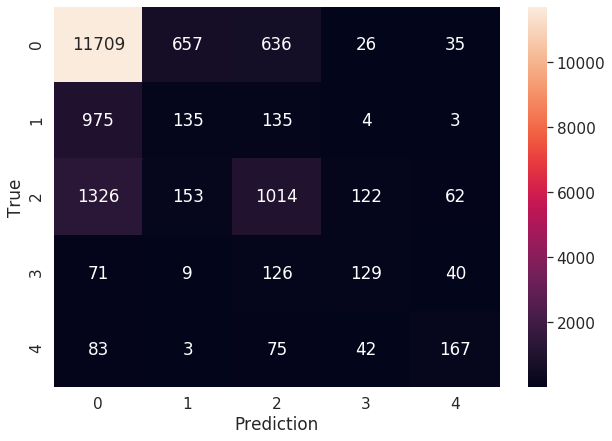

In [83]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Add more Dense

In [84]:
def create_toplayers(base):
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)
    lyr_dense4 = Dense(128, activation='relu')(lyr_dense3)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense4)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [85]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [86]:
model_fp = 'tune/smote_moreDense.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [87]:
model = create_toplayers(base)
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
191/191 [==============================] - 2s 8ms/step - loss: 1.2480 - accuracy: 0.4322 - val_loss: 1.1627 - val_accuracy: 0.4584

Epoch 00001: val_accuracy improved from -inf to 0.45835, saving model to tune/smote_moreDense.h5
Epoch 2/200
191/191 [==============================] - 1s 6ms/step - loss: 0.9926 - accuracy: 0.5615 - val_loss: 0.9811 - val_accuracy: 0.5735

Epoch 00002: val_accuracy improved from 0.45835 to 0.57353, saving model to tune/smote_moreDense.h5
Epoch 3/200
191/191 [==============================] - 1s 6ms/step - loss: 0.9253 - accuracy: 0.5948 - val_loss: 0.8808 - val_accuracy: 0.6409

Epoch 00003: val_accuracy improved from 0.57353 to 0.64091, saving model to tune/smote_moreDense.h5
Epoch 4/200
191/191 [==============================] - 1s 6ms/step - loss: 0.8730 - accuracy: 0.6199 - val_loss: 1.0093 - val_accuracy: 0.5168

Epoch 00004: val_accuracy did not improve from 0.64091
Epoch 5/200
191/191 [==============================] - 1s 6ms/step - los

In [88]:
model = load_model('tune/smote_moreDense.h5')

In [89]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7336077126909849
Classification Report
              precision    recall  f1-score   support

           0      0.827     0.884     0.855     13063
           1      0.124     0.111     0.117      1252
           2      0.491     0.387     0.433      2677
           3      0.451     0.320     0.374       375
           4      0.612     0.443     0.514       370

    accuracy                          0.734     17737
   macro avg      0.501     0.429     0.459     17737
weighted avg      0.714     0.734     0.722     17737



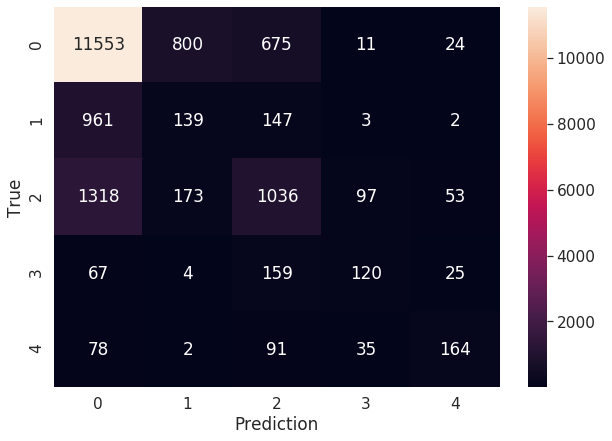

In [90]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Add more Dense with Bias

In [91]:
def create_toplayers(base):
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu',
                       bias_initializer='ones')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)
    lyr_dense4 = Dense(128, activation='relu')(lyr_dense3)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense4)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [92]:
batch_size = 1024
train_steps = len(y_train_sm) // batch_size
val_steps = len(y_val_true) // batch_size

In [93]:
model_fp = 'tune/smote_moreDense_bias.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=1, save_best_only=True)

In [94]:
model = create_toplayers(base)
model.fit(x_train_sm, y_train_sm,
          batch_size = batch_size,
          steps_per_epoch=train_steps,
          validation_data = (x_val_vec, y_val_bin),
          validation_steps = val_steps,
          validation_batch_size = batch_size,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early])

Epoch 1/200
191/191 [==============================] - 2s 7ms/step - loss: 1.4183 - accuracy: 0.3739 - val_loss: 1.4089 - val_accuracy: 0.2188

Epoch 00001: val_accuracy improved from -inf to 0.21881, saving model to tune/smote_moreDense_bias.h5
Epoch 2/200
191/191 [==============================] - 1s 6ms/step - loss: 1.0451 - accuracy: 0.5356 - val_loss: 1.1128 - val_accuracy: 0.4751

Epoch 00002: val_accuracy improved from 0.21881 to 0.47507, saving model to tune/smote_moreDense_bias.h5
Epoch 3/200
191/191 [==============================] - 1s 6ms/step - loss: 0.9686 - accuracy: 0.5755 - val_loss: 1.4107 - val_accuracy: 0.2783

Epoch 00003: val_accuracy did not improve from 0.47507
Epoch 4/200
191/191 [==============================] - 1s 6ms/step - loss: 0.9194 - accuracy: 0.5985 - val_loss: 0.9499 - val_accuracy: 0.5918

Epoch 00004: val_accuracy improved from 0.47507 to 0.59180, saving model to tune/smote_moreDense_bias.h5
Epoch 5/200
191/191 [==============================] - 1s

191/191 [==============================] - 1s 6ms/step - loss: 0.0097 - accuracy: 0.9979 - val_loss: 2.8015 - val_accuracy: 0.7317

Epoch 00080: val_accuracy improved from 0.73156 to 0.73168, saving model to tune/smote_moreDense_bias.h5
Epoch 81/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0110 - accuracy: 0.9973 - val_loss: 2.8180 - val_accuracy: 0.7223

Epoch 00081: val_accuracy did not improve from 0.73168
Epoch 82/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0341 - accuracy: 0.9889 - val_loss: 2.4943 - val_accuracy: 0.6974

Epoch 00082: val_accuracy did not improve from 0.73168
Epoch 83/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0186 - accuracy: 0.9944 - val_loss: 2.6567 - val_accuracy: 0.7244

Epoch 00083: val_accuracy did not improve from 0.73168
Epoch 84/200
191/191 [==============================] - 1s 6ms/step - loss: 0.0073 - accuracy: 0.9990 - val_loss: 2.7367 - val_accuracy: 0.7242

Epoch 00084: val_a

In [95]:
model = load_model('tune/smote_moreDense_bias.h5')

In [96]:
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7356937475334048
Classification Report
              precision    recall  f1-score   support

           0      0.831     0.885     0.857     13063
           1      0.151     0.104     0.123      1252
           2      0.457     0.397     0.425      2677
           3      0.369     0.331     0.349       375
           4      0.565     0.459     0.507       370

    accuracy                          0.736     17737
   macro avg      0.475     0.435     0.452     17737
weighted avg      0.711     0.736     0.722     17737



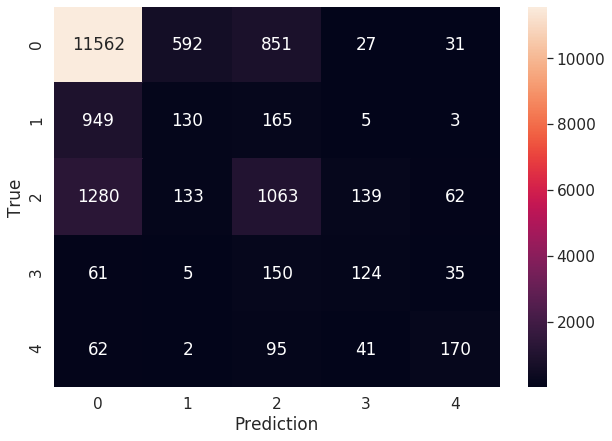

In [97]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

### Result of SMOTE Oversampling and Fine Tuning

After simulating different network architectures, the group found that adding the more layers to the network with class weights yields the best result. With a traning accuracy of 96.1% and validation accuracy of 74.2%. The model achieved a 71.6% precision and 74.2% recall. Even though the using SMOTE oversampling outperforms oversampling with replacement in training accuracy, the result of the previous section is more robust and generalizable.

# Final Evaluation of Tuned models

After fine tuning the InceptionResNet-V2 model, this section compare its performance to the Xception and Vgg16 base models.

In [141]:
# Define the function that creates the tuned architecture
def create_toplayers(base):
    """Create top layer using inceptionb resnet v2 base"""
    # Create input layer based on the output of the convolutional base
    lyr_input = Input(shape=(base.layers[-1].output.shape.as_list()[1], ))

    # Add Dense
    lyr_dense1 = Dense(1024, activation='relu')(lyr_input)
    lyr_dense2 = Dense(512, activation='relu')(lyr_dense1)
    lyr_dense3 = Dense(256, activation='relu')(lyr_dense2)

    # Create output layer
    output = Dense(5, activation='softmax')(lyr_dense3)

    model = Model(inputs=[lyr_input], outputs=[output])
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

## Xception

In [147]:
train_data_over = (xception_data.filter(lambda x: x['name'] in
                                        x_train_over.values)
                   .map(lambda x: {x['name']: np.asarray(x['value'])})
                   .fold(binop=lambda x, y: join_dict(x, y),
                         combine=lambda x, y: join_dict(x, y))
                   .compute())

In [148]:
val_data = (xception_data.filter(lambda x: x['name'] in x_val.values)
            .map(lambda x: {x['name']: np.asarray(x['value'])})
            .fold(binop=lambda x, y: join_dict(x, y),
                  combine=lambda x, y: join_dict(x, y))
            .compute())

In [149]:
val = [[vector, val_labels[img_fn]] for img_fn, vector in val_data.items()]
x_val_vec = np.array(list(map(lambda x: x[0], val)))
y_val_true = list(map(lambda x: x[1], val))

y_val_bin = np.array(
    list(map(lambda x: to_categorical([x], num_classes=5)[0], y_val_true)))
del val

### Build and train model

In [150]:
batch_size = 1024

train_gen = data_generator(train_labels_over, train_data_over, batch_size)
val_gen = data_generator(val_labels, val_data, batch_size)

model_fp = 'tune/xception_final.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=0, save_best_only=True)
base = create_xception_base()
model = create_toplayers(base)
model.fit(train_gen,
          steps_per_epoch=train_steps,
          validation_data = val_gen,
          validation_steps = val_steps,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early],
          verbose=0)

Epoch 00149: early stopping


### Evaluate the result

In [151]:
model = load_model(model_fp)
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7551446129559678
Classification Report
              precision    recall  f1-score   support

           0      0.785     0.970     0.868     13063
           1      0.000     0.000     0.000      1252
           2      0.456     0.201     0.279      2677
           3      0.403     0.077     0.130       375
           4      0.445     0.416     0.430       370

    accuracy                          0.755     17737
   macro avg      0.418     0.333     0.341     17737
weighted avg      0.665     0.755     0.693     17737



/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


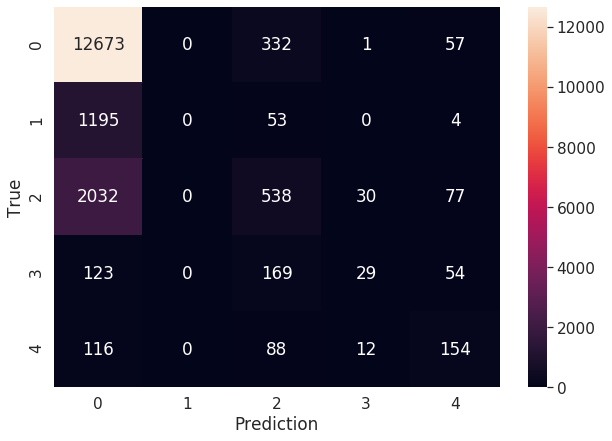

In [154]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

## VGG 16

In [155]:
train_data_over = (vgg_data.filter(lambda x: x['name'] in
                                   x_train_over.values)
                   .map(lambda x: {x['name']: np.asarray(x['value'])})
                   .fold(binop=lambda x, y: join_dict(x, y),
                         combine=lambda x, y: join_dict(x, y))
                   .compute())

In [156]:
val_data = (vgg_data.filter(lambda x: x['name'] in x_val.values)
            .map(lambda x: {x['name']: np.asarray(x['value'])})
            .fold(binop=lambda x, y: join_dict(x, y),
                  combine=lambda x, y: join_dict(x, y))
            .compute())

In [157]:
val = [[vector, val_labels[img_fn]] for img_fn, vector in val_data.items()]
x_val_vec = np.array(list(map(lambda x: x[0], val)))
y_val_true = list(map(lambda x: x[1], val))

y_val_bin = np.array(
    list(map(lambda x: to_categorical([x], num_classes=5)[0], y_val_true)))
del val

### Build and train model

In [158]:
batch_size = 1024

train_gen = data_generator(train_labels_over, train_data_over, batch_size)
val_gen = data_generator(val_labels, val_data, batch_size)

model_fp = 'tune/vgg_final.h5'
checkpoint = ModelCheckpoint(model_fp,
                             monitor='val_accuracy',
                             verbose=0, save_best_only=True)
base = create_vgg_base()
model = create_toplayers(base)
model.fit(train_gen,
          steps_per_epoch=train_steps,
          validation_data = val_gen,
          validation_steps = val_steps,
          epochs=200,
          callbacks=[checkpoint, reduceLROnPlat, early],
          verbose=0)

Epoch 00063: early stopping


### Evaluate the result

In [159]:
model = load_model(model_fp)
y_val_pred = np.argmax(model.predict(x_val_vec), axis=1)

Accuracy: 0.7364830580143203
Classification Report
              precision    recall  f1-score   support

           0      0.736     1.000     0.848     13063
           1      0.000     0.000     0.000      1252
           2      0.000     0.000     0.000      2677
           3      0.000     0.000     0.000       375
           4      0.000     0.000     0.000       370

    accuracy                          0.736     17737
   macro avg      0.147     0.200     0.170     17737
weighted avg      0.542     0.736     0.625     17737



/home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


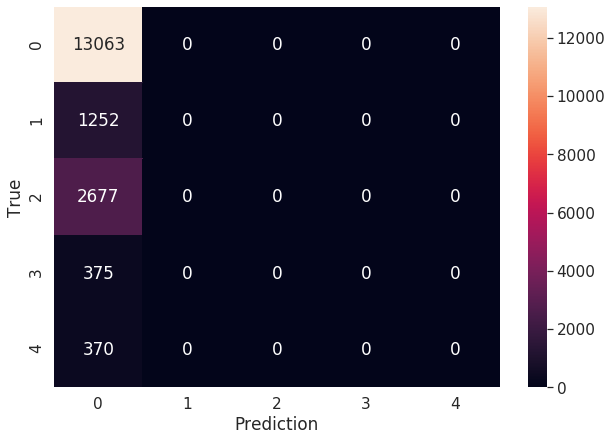

In [160]:
evaluate(y_val_true, y_val_pred)
warnings.filterwarnings("default")

## Result of Fine Tuning of all models

After simulating different network architectures and convolutional base, the group found that using the InceptionResNet-V2 model yields the best accuracy, precision and recall in the validation dataset. With a traning accuracy of 74.36% and validation accuracy of 79%, the model outperforms the two other models simulated in this section. The InceptionResNet-V2 achieved a 78.9% precision and 79% recall, beating the precision of both Xception and VGG16 base.

|   	| Base               	| Validation Acc% 	| W. Precision% 	| W. Recall% 	|
|---	|--------------------	|--------------	|---------------	|------------	|
| 1 	| Xception           	| 73.65        	| 54.2          	| 73.6       	|
| 2 	| InceptionResNet-V2 	| 79.03        	| 78.9          	| 79         	|
| 3 	| VGG16              	| 78.89        	| 71.7          	| 78.9       	|

### Evaluate Final model on Test Dataset

In [165]:
test_data = (inception_data.filter(lambda x: x['name'] in x_test.values)
            .map(lambda x: {x['name']: np.asarray(x['value'])})
            .fold(binop=lambda x, y: join_dict(x, y),
                  combine=lambda x, y: join_dict(x, y))
            .compute())

In [166]:
test = [[vector, test_labels[img_fn]] for img_fn, vector in test_data.items()]
x_test_vec = np.array(list(map(lambda x: x[0], test)))
y_test_true = list(map(lambda x: x[1], test))

y_test_bin = np.array(
    list(map(lambda x: to_categorical([x], num_classes=5)[0], y_test_true)))
del test

In [172]:
model = load_model('tune/resample_dropToDense.h5')
y_test_pred = np.argmax(model.predict(x_test_vec), axis=1)

Accuracy: 0.7888801172888237
Classification Report
              precision    recall  f1-score   support

           0      0.825     0.966     0.890     13056
           1      0.000     0.000     0.000      1231
           2      0.564     0.389     0.461      2613
           3      0.469     0.366     0.411       432
           4      0.651     0.498     0.564       402

    accuracy                          0.789     17734
   macro avg      0.502     0.444     0.465     17734
weighted avg      0.717     0.789     0.746     17734



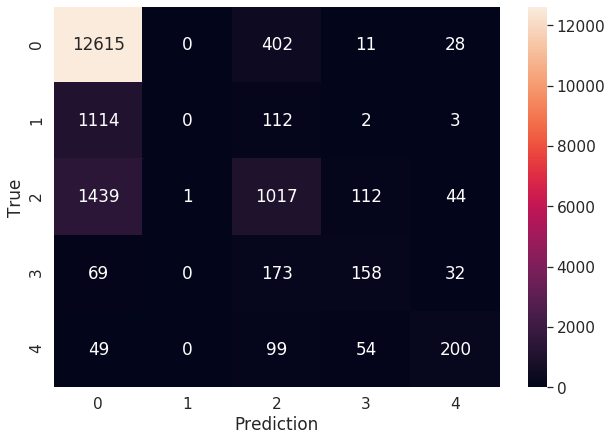

In [173]:
evaluate(y_test_true, y_test_pred)
warnings.filterwarnings("default")

The result above shows that the model performed well in unseen data with an accuracy of 78.89%. This accuracy beats the heuristic chance accuracy criteria of 25%. However, the model has difficulty in classifying level 1 diabetic retinopathy.

# Conclusion and Recommendation

# References